# Validation of `RIMEz` against `pyuvsim` reference simulations

Lily Whitler, Steven Murray, and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

We compare point-source visibilities simulated with `RIMEz` to the first set of reference simulations produced by `pyuvsim`.

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy import constants as const

import uvtools
from pyuvdata import UVData

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [4]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2020-05-18 14:29:58.888724


- **Major Step Description:** {Insert standard description of major step}
- **Minor Variation Description:** {Insert standard description of minor step}
- **Pipelines Tested:** {Brief list of explicit pipelines tested in the notebook}
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `a8f6b6fdd7261`}
* {If you have the Python Markdown extension, you can do this: ``pyuvdata``: ``{pyuvdata.version.git_hash}``
* {``hera_qm``: `f3e32c3cef36cbd`}
* {etc.}

Versions of other software used in this validation test:

* {``numpy``: vx.x.x}
* {etc. (only list imported modules).}

### Utility Functions

In [5]:
# Omnibus plotting function that got out of hand, I'll split this up later
def plot_comparison(ref_uvd, rimez_uvd, bls, times, alt_az,
                    horizon_cross=None,
                    pol='ee', component='amp',
                    difference=False, diff_first=True,
                    fig=None, colors=['#5296C1', '#2F0F3E']):
    # Map between X/Y and E/N polarizations
    # X is east and Y is north in pyuvsim, per Adam Lanman
    x_orientation, y_orientation = 'e', 'n'
    ref_pols, rimez_pols = ref_uvd.get_pols(), rimez_uvd.get_pols()
    pol_dict = {}
    for xy_pol in ref_pols:
        en_pol = xy_pol.replace('x', x_orientation).replace('y', y_orientation)
        pol_dict[en_pol] = xy_pol  # Mapping between E/N and X/Y
                
    if component == 'real':
        function = np.real
        name = 'Real'
    elif component == 'imag':
        function = np.imag
        name = 'Imag'
    elif component == 'amp':
        function = np.abs
        name = 'Amp'
    elif component == 'phase':
        function = np.angle
        name = 'Phase'
    
    if fig is None:
        fig = plt.gcf()
    ax = fig.axes  # This gives a list, even if there's only one subplot
    
    alt_az_cols, alt_az_lines = ['#3B4F8A', '#3FBC72'], ['-', '--']
    ax[0].axhline(0, c='#6B6B6B', ls=':', lw=1.5)
    for i, aa in enumerate(alt_az):
        ax[0].plot(times, aa.alt, c=alt_az_cols[i % 2], ls=alt_az_lines[i % 2])
        ax[1].plot(times, aa.az, c=alt_az_cols[i % 2], ls=alt_az_lines[i % 2])
    ax[0].set_ylabel('Alt  [$^\circ$]')
    ax[1].set_ylabel('Az  [$^\circ$]')
        
    for i, bl in enumerate(bls):
        ant1, ant2 = ref_uvd.baseline_to_antnums(bl)
        key_ref = (ant1, ant2, pol_dict[pol])
        key_rimez = (ant1, ant2, pol)
        
        if horizon_cross is not None:
            for cross in horizon_cross:
                ax[i].axvspan(times[cross-1], times[cross], color='#6B6B6B')
        
        # Plot the difference
        if difference:
            times = ref_uvd.get_times(key_ref)
            if diff_first:
                diff_data = function(rimez_uvd.get_data(key_rimez) - ref_uvd.get_data(key_ref))
                label = '{}(RIMEz - reference)'.format(name)
            else:
                diff_data = function(rimez_uvd.get_data(key_rimez)) - function(ref_uvd.get_data(key_ref))
                label = '{}(RIMEz) - {}(reference)'.format(name, name)
            ax[i+2].axhline(0, c='#6B6B6B', ls=':', lw=1.5)
            ax[i+2].plot(times, diff_data, c=colors[1], label=label)
            ncols = 1
            
        # Or just overplot the visibilities
        else:
            ref_data = function(ref_uvd.get_data(key_ref))
            rimez_data = function(rimez_uvd.get_data(key_rimez))
            ax[i+2].plot(times, ref_data, c=colors[0], label='reference')
            ax[i+2].plot(times, rimez_data, c=colors[1], ls='-', label='RIMEz')
            ncols = 2
        ax[i+2].set_ylabel(name)
        ax[i+2].text(1.02, 0.5, '({}, {})'.format(ant1, ant2), ha='center',
                   va='center', rotation=270, transform=ax[i+2].transAxes)
    ax[-1].set_xlabel('Time')
    ax[-1].legend(loc='center', ncol=ncols, frameon=False, bbox_to_anchor=(0.5, -0.85))
    fig.tight_layout()

### Data

The following paths point to the configuration files used to create the `RIMEz` simulations used in this notebook, but are never read here.

In [6]:
config_base = '/home/lwhitler/src/pyuvsim/reference_simulations/first_reference_simulations'
config_dict = {'1.1_uniform': os.path.join(config_base, 'obsparam_ref_1.1_downsampled_mwa.yaml'),
               '1.2_uniform': os.path.join(config_base, 'obsparam_ref_1.2_uniform.yaml'),
               '1.2_gauss': os.path.join(config_base, 'obsparam_ref_1.2_gauss.yaml'),
               '1.3_uniform': os.path.join(config_base, 'obsparam_ref_1.3_uniform.yaml'),
               '1.3_gauss': os.path.join(config_base, 'obsparam_ref_1.3_gauss.yaml')}

for key in config_dict.keys():
    print('{}: {}'.format(key, config_dict[key]))

1.1_uniform: /home/lwhitler/src/pyuvsim/reference_simulations/first_reference_simulations/obsparam_ref_1.1_downsampled_mwa.yaml
1.2_uniform: /home/lwhitler/src/pyuvsim/reference_simulations/first_reference_simulations/obsparam_ref_1.2_uniform.yaml
1.2_gauss: /home/lwhitler/src/pyuvsim/reference_simulations/first_reference_simulations/obsparam_ref_1.2_gauss.yaml
1.3_uniform: /home/lwhitler/src/pyuvsim/reference_simulations/first_reference_simulations/obsparam_ref_1.3_uniform.yaml
1.3_gauss: /home/lwhitler/src/pyuvsim/reference_simulations/first_reference_simulations/obsparam_ref_1.3_gauss.yaml


The following paths reflect the exact locations of all data used in this test. The `RIMEz` data was created with the script found at `/home/lwhitler/data/validation/rimez/prepare_rimez_data.py`.

In [7]:
# All paths are temporarily on Enterprise until I can move things to Lustre
ref_path = '/home/lwhitler/src/pyuvsim/reference_simulations/latest_ref_data/v1'
ref_path_dict = {'1.1_uniform': os.path.join(ref_path, 'ref_1.1_uniform.uvh5'),
                 '1.2_uniform': os.path.join(ref_path, 'ref_1.2_uniform.uvh5'),
                 '1.2_gauss': os.path.join(ref_path, 'ref_1.2_gauss.uvh5'),
                 '1.3_uniform': os.path.join(ref_path, 'ref_1.3_uniform.uvh5'),
                 '1.3_gauss': os.path.join(ref_path, 'ref_1.3_gauss.uvh5')}

# There is some trickiness with values of lmax in filenames--this will be addressed later
rimez_path = '/home/lwhitler/data/validation/rimez/rimez_sims'
rimez_path_dict = {'1.1_uniform': os.path.join(rimez_path, 'rimez_1.1_uniform_lmax249.uvh5'),
                   '1.2_uniform': os.path.join(rimez_path, 'rimez_1.2_uniform_lmax250.uvh5'),
                   '1.2_gauss': os.path.join(rimez_path, 'rimez_1.2_gauss_lmax250.uvh5'),
                   '1.3_uniform': os.path.join(rimez_path, 'rimez_1.3_uniform_lmax470.uvh5'),
                   '1.3_gauss': os.path.join(rimez_path, 'rimez_1.3_gauss_lmax470.uvh5')}

## Reference simulations 1.2 (long time axis)

In [8]:
uvd_ref_12_uniform, uvd_ref_12_gauss = UVData(), UVData()
uvd_ref_12_uniform.read(ref_path_dict['1.2_uniform'], run_check_acceptability=False)
uvd_ref_12_gauss.read(ref_path_dict['1.2_gauss'], run_check_acceptability=False)

uvd_rimez_12_uniform, uvd_rimez_12_gauss = UVData(), UVData()
uvd_rimez_12_uniform.read(rimez_path_dict['1.2_uniform'], run_check_acceptability=False)
uvd_rimez_12_gauss.read(rimez_path_dict['1.2_gauss'], run_check_acceptability=False)

Telescope BLLITE is not in known_telescopes.
Telescope RIMEz is not in known_telescopes.


### Array layout

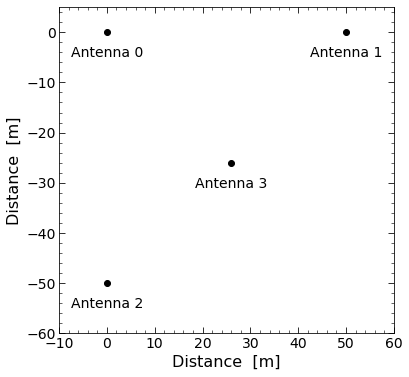

In [14]:
antpos, ants = uvd_ref_12_uniform.get_ENU_antpos()
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(ants)):
    ax1.scatter(antpos[i, 0], antpos[i, 1], c='k')
    ax1.text(antpos[i, 0], antpos[i, 1]-5, 'Antenna {}'.format(i), ha='center', fontsize=14)
ax1.set_xlabel('Distance  [m]')
ax1.set_ylabel('Distance  [m]')
ax1.set_xlim([-10, 60])
ax1.set_ylim([-60, 5]);

In [16]:
# NOTE: Would like to be able to plot the source path -- save alt/az from another notebook?

### Uniform beam

In [ ]:
# Overplot amplitudes
fig3, ax3 = plt.subplots(len(bls)+2, 1, sharex='col', figsize=(8, 9))
plot_comparison(ref_uniform, rimez_uniform, bls, times, alt_az, horizon_cross, component='amp', fig=fig3)
for ax in ax3[2:]:
    ax.set_ylim([0.495, 0.505])

### Gaussian beam

## Reference Simulations 1.3 (long frequency axis)

### Uniform beam

### Gaussian beam